In [332]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras
print(keras.backend.backend())

tensorflow


In [333]:
from keras import layers,losses,metrics,activations,callbacks,regularizers,optimizers
import numpy as np
import pandas as pd
import os,datetime,pickle,sklearn,mlflow,datetime

In [334]:
#load data
path = os.path.join(os.getcwd(),"dataset","ecommerceDataset.csv")
df=pd.read_csv(path, names = ['category', 'text'])

In [335]:
#inspect data
print(df.head())
print(df.info()) #one null value both are object
print(df['category'].unique()) #['Household' 'Books' 'Clothing & Accessories' 'Electronics']

    category                                               text
0  Household  Paper Plane Design Framed Wall Hanging Motivat...
1  Household  SAF 'Floral' Framed Painting (Wood, 30 inch x ...
2  Household  SAF 'UV Textured Modern Art Print Framed' Pain...
3  Household  SAF Flower Print Framed Painting (Synthetic, 1...
4  Household  Incredible Gifts India Wooden Happy Birthday U...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50425 entries, 0 to 50424
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  50425 non-null  object
 1   text      50424 non-null  object
dtypes: object(2)
memory usage: 788.0+ KB
None
['Household' 'Books' 'Clothing & Accessories' 'Electronics']


In [336]:
print(df.iloc[4,1])

Incredible Gifts India Wooden Happy Birthday Unique Personalized Gift (5 X 4 Inch) Size:4 x 5   Made Of Natural Imported Wood, Which Is Quite Solid With Light Particle Pattern & Is Soft Pale To Blond Colour. Your Uploaded Photo Will Look Amazing And Beautiful After Laser Engraving On It. This Is One Of The Most Popular Unique Gifts In Our Store. We Offer This In Multiple Sizes, Some Can Be Used As Table Top And The Big Sizes Can Be Used As Wall Hanging Which Just Blends With Your Home Decaration. You Just Need To Upload A Picture And Add Your Own Text And We Will Do The Rest For You. We Will Email You The Preview Before Making The Final Product. Do You Want The Best Moment Of Your Life To Be Engraved On A Wooden Plaque That Lasts For A Longer Time And Stays Close To You Forever? Then You Are At The Right Place. We Present To You Various Sizes Personalized Engraved Wooden Plaques Made With Birch Wood. Let Your Memories Be Engraved On Wooden Plaques And Stay With Your Forever.


In [337]:
'''
Unequal distribution between class might reduced accuracy.
Solution possible: extract more data for the lacking category or duplicate data
Hence check data if duplicates exist and compare 
'''
print(df.count())
nClass = len(df['category'].value_counts())
Class = df['category'].value_counts()
print('number of unique class',nClass)
print(Class)
print('')
print("duplicated values: ",df.duplicated().sum())
print('')
df_drop = df.copy().drop_duplicates()
nClass = len(df_drop['category'].value_counts())
Class = df_drop['category'].value_counts()
print('number of unique class',nClass)
print(Class)
print(df.count())

category    50425
text        50424
dtype: int64
number of unique class 4
category
Household                 19313
Books                     11820
Electronics               10621
Clothing & Accessories     8671
Name: count, dtype: int64

duplicated values:  22622

number of unique class 4
category
Household                 10564
Books                      6256
Clothing & Accessories     5675
Electronics                5308
Name: count, dtype: int64
category    50425
text        50424
dtype: int64


In [338]:
#Drop duplicates in books to balance the distribution
df_drop = df[~((df['category']=='Household') & (df.duplicated()))]
#print(df.head())
print(df_drop['category'].value_counts())
df = df_drop

category
Books                     11820
Electronics               10621
Household                 10564
Clothing & Accessories     8671
Name: count, dtype: int64


In [339]:
# drop null
df = df.dropna()
print(df.isna().sum())

category    0
text        0
dtype: int64


In [340]:
#4. Split into features and label
feature = df['text'].values
label = df['category'].values
#encode label
label_encoder = sklearn.preprocessing.LabelEncoder()
label_encoded = label_encoder.fit_transform(label)
print(np.unique(label_encoded))
print(label_encoder.inverse_transform(np.unique(label_encoded)))


[0 1 2 3]
['Books' 'Clothing & Accessories' 'Electronics' 'Household']


In [341]:
#Split data into try test and validation by 70:15:15
seed = 42
x_train, x_split, y_train, y_split = sklearn.model_selection.train_test_split(feature,label_encoded, train_size=0.7,random_state=seed)
x_test,x_val, y_test, y_val = sklearn.model_selection.train_test_split(x_split,y_split, train_size=0.5,random_state=seed)

In [342]:
# NLP process
# TOKENIZATION
vocab_size = 5000
tokenizer = layers.TextVectorization(max_tokens=vocab_size, output_sequence_length=250)
tokenizer.adapt(x_train)

In [343]:
# test the tokens
print(tokenizer.get_vocabulary())
sample_texts = x_train[:2]
sample_tokens = tokenizer(x_train)
print(sample_texts[0])
print(sample_tokens[0])

['', '[UNK]', np.str_('the'), np.str_('and'), np.str_('of'), np.str_('to'), np.str_('a'), np.str_('for'), np.str_('in'), np.str_('with'), np.str_('is'), np.str_('your'), np.str_('you'), np.str_('it'), np.str_('this'), np.str_('on'), np.str_('that'), np.str_('from'), np.str_('or'), np.str_('as'), np.str_('can'), np.str_('are'), np.str_('be'), np.str_('an'), np.str_('has'), np.str_('all'), np.str_('at'), np.str_('by'), np.str_('book'), np.str_('he'), np.str_('will'), np.str_('about'), np.str_('author'), np.str_('have'), np.str_('not'), np.str_('his'), np.str_('x'), np.str_('1'), np.str_('which'), np.str_('its'), np.str_('also'), np.str_('one'), np.str_('up'), np.str_('quality'), np.str_('use'), np.str_('our'), np.str_('more'), np.str_('size'), np.str_('set'), np.str_('product'), np.str_('made'), np.str_('new'), np.str_('easy'), np.str_('black'), np.str_('design'), np.str_('any'), np.str_('usb'), np.str_('2'), np.str_('we'), np.str_('high'), np.str_('power'), np.str_('cotton'), np.str_('o

In [344]:
# EMBEDDING
embedding = layers.Embedding(input_dim=vocab_size,output_dim=64)


In [345]:
# Create keras model
model = keras.Sequential()
# NLP layer
model.add(tokenizer)
model.add(embedding)
# Add RNN layers
model.add(layers.Bidirectional(layers.LSTM(8,return_sequences=True)))
model.add(layers.Bidirectional(layers.LSTM(8,return_sequences=False)))
model.add(layers.Dropout(rate=(0.5)))
model.add(layers.Dense(nClass,activation="softmax"))

In [346]:
# 8 Compile the model
loss_ = losses.SparseCategoricalCrossentropy(from_logits=False)
schedule = optimizers.schedules.CosineDecay(
    initial_learning_rate =0.0001,
    decay_steps = 100,
    warmup_target=0.001,
    warmup_steps=1,
)
keras.optimizers.Adam(learning_rate=schedule)
model.compile(optimizer='adam', loss=loss_, metrics=['accuracy'])

In [347]:
log_path = os.path.join(os.getcwd(),"logs",datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
ts = callbacks.TensorBoard(log_dir=log_path)
stop = keras.callbacks.EarlyStopping(patience=2,verbose=1)
history = model.fit(x_train,y_train,validation_data=(x_val,y_val),epochs=15, batch_size=64, callbacks=[ts,stop])

Epoch 1/15
456/456 ━━━━━━━━━━━━━━━━━━━━ 50s 101ms/step - accuracy: 0.6058 - loss: 0.9837 - val_accuracy: 0.9387 - val_loss: 0.2746
Epoch 2/15
456/456 ━━━━━━━━━━━━━━━━━━━━ 43s 94ms/step - accuracy: 0.9071 - loss: 0.3536 - val_accuracy: 0.9491 - val_loss: 0.2004
Epoch 3/15
456/456 ━━━━━━━━━━━━━━━━━━━━ 46s 101ms/step - accuracy: 0.9260 - loss: 0.2702 - val_accuracy: 0.9547 - val_loss: 0.1728
Epoch 4/15
456/456 ━━━━━━━━━━━━━━━━━━━━ 44s 97ms/step - accuracy: 0.9351 - loss: 0.2215 - val_accuracy: 0.9592 - val_loss: 0.1607
Epoch 5/15
456/456 ━━━━━━━━━━━━━━━━━━━━ 44s 95ms/step - accuracy: 0.9411 - loss: 0.1839 - val_accuracy: 0.9597 - val_loss: 0.1597
Epoch 6/15
456/456 ━━━━━━━━━━━━━━━━━━━━ 47s 103ms/step - accuracy: 0.9492 - loss: 0.1599 - val_accuracy: 0.9597 - val_loss: 0.1801
Epoch 7/15
456/456 ━━━━━━━━━━━━━━━━━━━━ 44s 96ms/step - accuracy: 0.9657 - loss: 0.1294 - val_accuracy: 0.9602 - val_loss: 0.1747
Epoch 7: early stopping


In [348]:
#Evaluate model accuracy
print(model.evaluate(x_test,y_test))

#Evaluate model f1_score
f1_score = sklearn.metrics.f1_score
# Example data
y_true = y_test
y_pred = np.argmax(model.predict(x_test), axis=1)
# Calculate F1 score for each class separately
f1_per_class = f1_score(y_true, y_pred, average=None)
# Calculate micro-average F1 score
f1_micro = f1_score(y_true, y_pred, average='micro')
# Calculate macro-average F1 score
f1_macro = f1_score(y_true, y_pred, average='macro')
# Calculate weighted-average F1 score
f1_weighted = f1_score(y_true, y_pred, average='weighted')

print('F1 score per class:', f1_per_class)
print('Micro-average F1 score:', f1_micro)
print('Macro-average F1 score:', f1_macro)
print('Weighted-average F1 score:', f1_weighted)

196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.9591 - loss: 0.1830
[0.17132893204689026, 0.9603263735771179]
196/196 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step
F1 score per class: [0.96885617 0.97413793 0.95834638 0.9420155 ]
Micro-average F1 score: 0.9603263477843546
Macro-average F1 score: 0.9608389974407663
Weighted-average F1 score: 0.9602275514115507


In [349]:
#test predict value
index = 6
pred = label_encoder.inverse_transform([y_pred[index]])
actual = label_encoder.inverse_transform([y_test[index]])
print('text \n',x_test[index])
print(f'predicted: {pred[0]} actual: {actual[0]}')

text 
 Happy Chef Acrylic Cake Stand Revolving Server(12-inch, Silver) Material is Acrylic. Colour comes in Silver. 12 inch cake stand turn table.
predicted: Household actual: Household


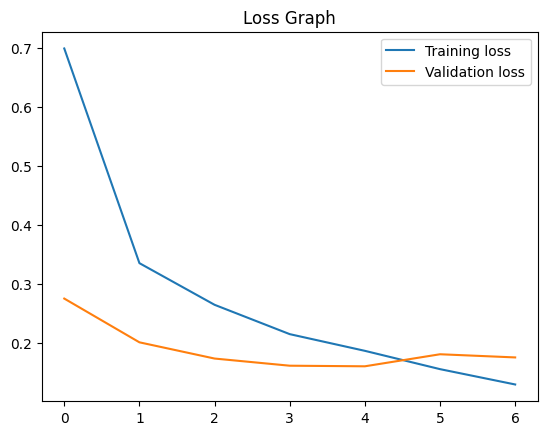

In [350]:
#plot metrics graphs
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Graph')
plt.legend(['Training loss','Validation loss'])
plt.show()

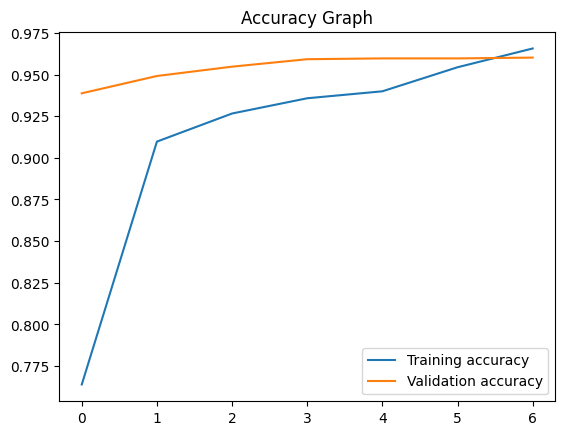

In [351]:
#plot metrics graphs
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy Graph')
plt.legend(['Training accuracy','Validation accuracy'])
plt.show()

In [352]:
#save the model
import pickle
model_path = "models\model.pkl"
with open (model_path,"wb") as file:
    pickle.dump(model,file)

#save the encoder
import pickle
encoder_path = "models\encoder.pkl"
with open (encoder_path,"wb") as file:
    pickle.dump(label_encoder,file)

<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:9: SyntaxWarning: invalid escape sequence '\e'
<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:9: SyntaxWarning: invalid escape sequence '\e'
C:\Users\suhaimi\AppData\Local\Temp\ipykernel_6808\2284666410.py:3: SyntaxWarning: invalid escape sequence '\m'
  model_path = "models\model.pkl"
C:\Users\suhaimi\AppData\Local\Temp\ipykernel_6808\2284666410.py:9: SyntaxWarning: invalid escape sequence '\e'
  encoder_path = "models\encoder.pkl"
